<a href="https://colab.research.google.com/github/chenyu313/Colaboratory_note/blob/main/%E8%B0%83%E8%AF%95%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 设置断点（breakpoint）
断点会停止你的代码执行，这样你就可以检查变量等等，并允许你的代码一次执行一行。  
在本例中，代码将在执行y = x**2行之前停止。



In [1]:
def function_to_debug():
    x = 2

    # set breakpoint
    import pdb

    pdb.set_trace()
    y = x**2

## 快速运行所有模型代码一次
如果你曾经训练一个模型几天，结果在验证或测试期间崩溃，那么这个训练器论点将成为你最好的朋友。  

训练器中的fast_dev_run参数通过训练器运行5批训练、验证、测试和预测数据，以查看是否有任何错误:

In [ ]:
! pip install --quiet "seaborn" "pytorch-lightning>=1.4, <2.0.0" "torchvision" "setuptools==67.4.0" "lightning>=2.0.0rc0" "ipython[notebook]==7.9.0" "pandas" "torchmetrics >=0.11.0" "torch>=1.8.1, <1.14.0" "torchmetrics>=0.7, <0.12"

In [3]:
import os

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [9]:
class LitMNIST(L.LightningModule):
  #⚡闪电模型
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):
        super().__init__()

        # 将初始化参数设置为类属性
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # 硬编码一些数据集特定的属性
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # 定义PyTorch模型
        self.model = nn.Sequential(
            nn.Flatten(), #展开
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),  #激活函数
            nn.Dropout(0.1), #暂退法，防止过拟合
            nn.Linear(hidden_size, hidden_size), #隐藏层
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # 调用self.log将为你在TensorBoard中显示标量
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # 调用self.log将为你在TensorBoard中显示标量
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # 下载
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # 为数据加载器分配train/val数据集
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # 为数据加载器分配test数据集
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [10]:
model = LitMNIST()
train=L.Trainer(fast_dev_run=True)
train.fit(model)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:lightning.pytorch.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/loops/fit_loop.py:280: Possi

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


若要更改要使用的批的数量，请将参数更改为整数。这里我们分别运行7批次:

In [11]:
model = LitMNIST()
train=L.Trainer(fast_dev_run=7)
train.fit(model)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Running in `fast_dev_run` mode: will run the requested loop using 7 batch(es). Logging and checkpointing is suppressed.
INFO:lightning.pytorch.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 7 batch(es). Logging and checkpointing is suppressed.
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accurac

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=7` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=7` reached.


该参数将禁用调谐器、检查点回调、早期停止回调、记录器和记录器回调，如LearningRateMonitor和DeviceStatsMonitor。

## 缩短epoch长度
有时只使用训练数据、val数据、测试数据或预测数据(或一组批次数据)的一小部分是有帮助的。例如，您可以使用20%的训练集和1%的验证集。  

在像Imagenet这样的大型数据集上，这可以帮助您更快地调试或测试一些东西，而不是等待完整的epoch。

In [14]:
# 只使用10%的训练数据和1%的val数据
trainer = L.Trainer(limit_train_batches=0.1, limit_val_batches=0.01)

# 使用10批次train和5批次val
trainer = L.Trainer(limit_train_batches=10, limit_val_batches=5)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


## 运行健全检查
Lightning在训练开始时运行2步验证。这避免了在长时间的训练循环中陷入验证循环。

In [15]:
trainer = L.Trainer(num_sanity_val_steps=2)
trainer.fit(model)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## 打印LightningModule权重摘要
每当调用.fit()函数时，训练器将打印LightningModule的权重摘要。  
trainer.fit(...)

要将子模块添加到摘要中，请添加ModelSummary:

In [16]:
from lightning.pytorch.callbacks import ModelSummary

trainer = L.Trainer(callbacks=[ModelSummary(max_depth=-1)])
trainer.fit(model)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_e

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


如果未调用.fit()，则打印模型摘要:

In [17]:
from lightning.pytorch.utilities.model_summary import ModelSummary

summary = ModelSummary(model, max_depth=-1)
print(summary)

   | Name          | Type               | Params
------------------------------------------------------
0  | model         | Sequential         | 55.1 K
1  | model.0       | Flatten            | 0     
2  | model.1       | Linear             | 50.2 K
3  | model.2       | ReLU               | 0     
4  | model.3       | Dropout            | 0     
5  | model.4       | Linear             | 4.2 K 
6  | model.5       | ReLU               | 0     
7  | model.6       | Dropout            | 0     
8  | model.7       | Linear             | 650   
9  | val_accuracy  | MulticlassAccuracy | 0     
10 | test_accuracy | MulticlassAccuracy | 0     
------------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


## 打印输入输出层尺寸
另一个调试工具是通过在LightningModule中设置example_input_array属性来显示所有层的中间输入和输出大小。

In [19]:
class LitModel(L.LightningModule):
    def __init__(self, *args, **kwargs):
        self.example_input_array = torch.Tensor(32, 1, 28, 28)

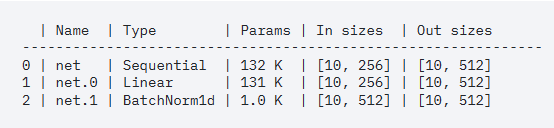